In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Here need to distinguish **ridge** and **edge**

In [3]:
dirName = 'figure/'
fewImName = '16_06_21_10E11c_P6210609_photo'
fewAnName = '16_06_21_10E11c_P6210609_annotation'
manyImName = '16_07_18_11E8c_P7181734_photo'
manyAnName = '16_07_18_11E8c_P7181734_annotation'

fewIm = plt.imread(os.path.join(dirName, fewImName + '.png'))
fewAn = plt.imread(os.path.join(dirName, fewAnName + '.png'))
manyIm = plt.imread(os.path.join(dirName, manyImName + '.png'))
manyAn = plt.imread(os.path.join(dirName, manyAnName + '.png'))

In [4]:
def showTwo(imA, imB):
    fig = plt.figure(figsize=(20,10))
    fig.add_subplot(1,2,1), plt.imshow(imA)
    fig.add_subplot(1,2,2), plt.imshow(imB);

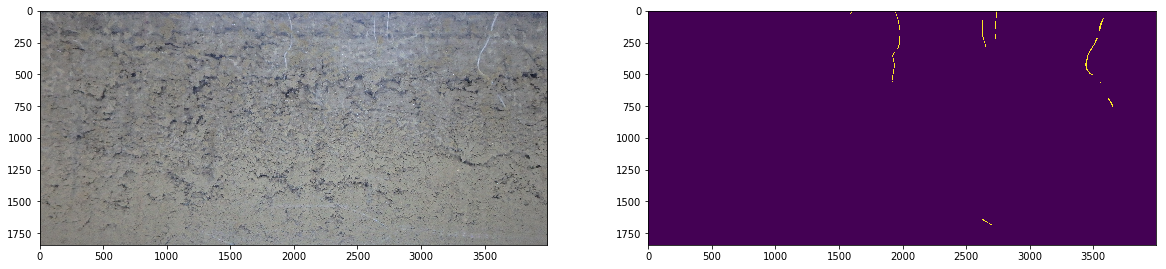

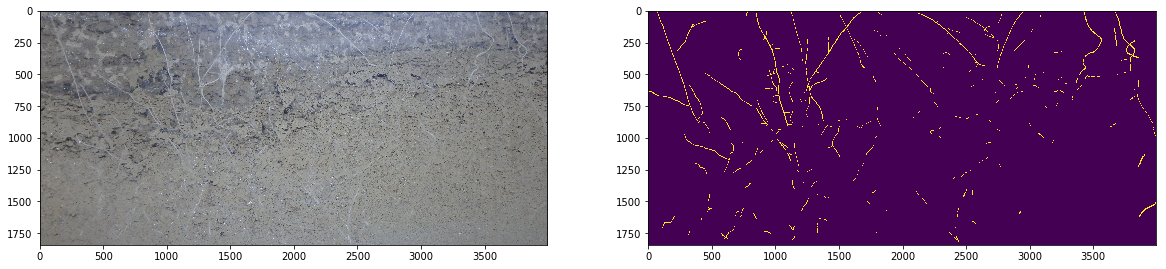

In [5]:
showTwo(fewIm, fewAn)
showTwo(manyIm, manyAn)

<class 'numpy.ndarray'>
(1842, 3991)
<class 'numpy.ndarray'>
(1842, 3991)
(1842, 3991)


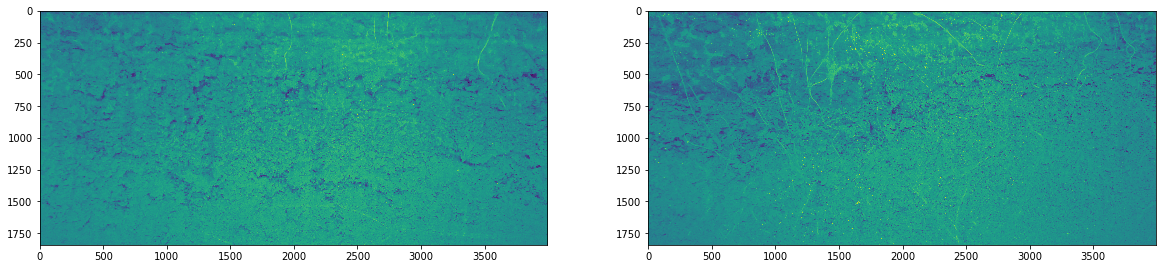

In [8]:
print(type(fewIm))
print(fewIm.shape)
print(type(fewAn))
print(fewAn.shape)
from skimage import color
fewIm = color.rgb2gray(fewIm)
manyIm = color.rgb2gray(manyIm)
print(fewIm.shape)
smallIm = fewIm[:1000,3000:]
smallAn = fewAn[:1000,3000:]
showTwo(fewIm, manyIm)

hessian matrix  which is computed by convolving the image with the second derivatives of the Gaussian kernel in the respective r- and c-directions.

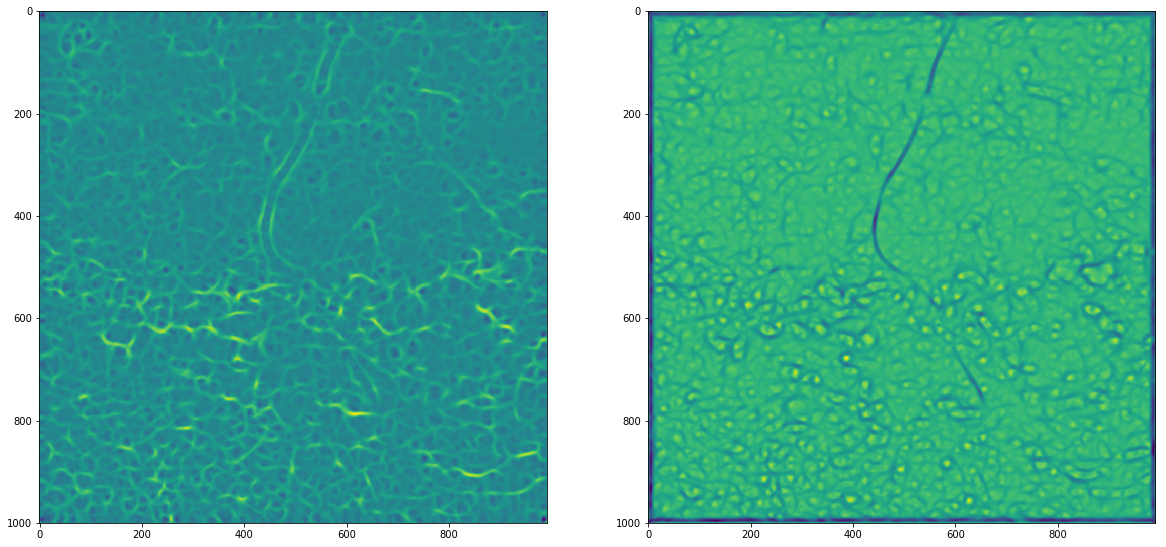

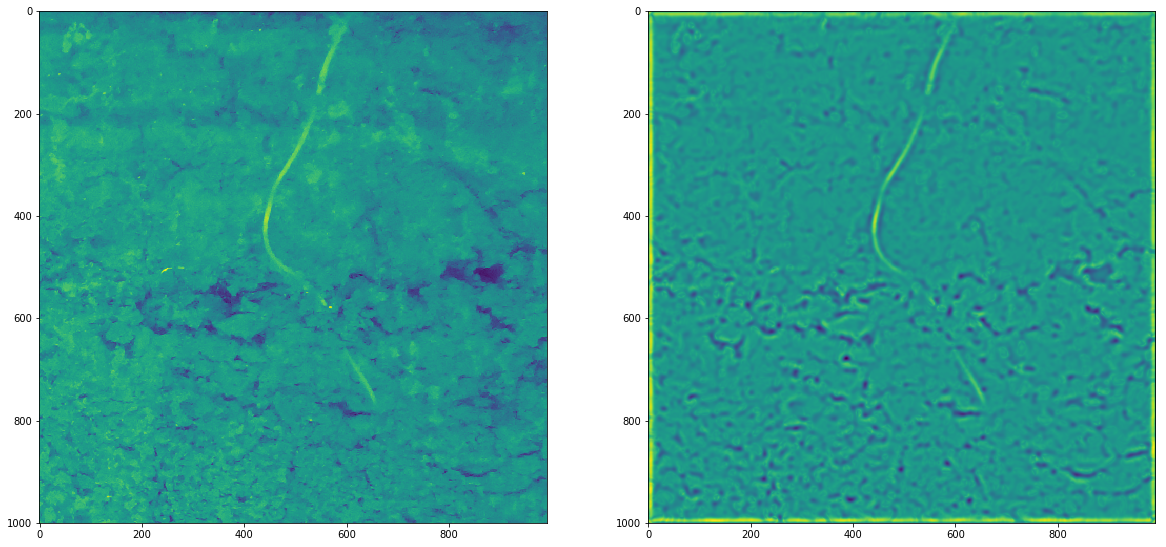

In [18]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

sigma = 5

# Compute Hessian in each point 
D = hessian_matrix(smallIm, sigma, order='rc')
# Calculate (abs sorted) eigenvalues and vectors
lambda1, lambda2 = hessian_matrix_eigvals(D)

ridge = -lambda2 - np.abs(lambda1)

showTwo(lambda1, lambda2)
showTwo(smallIm, ridge)


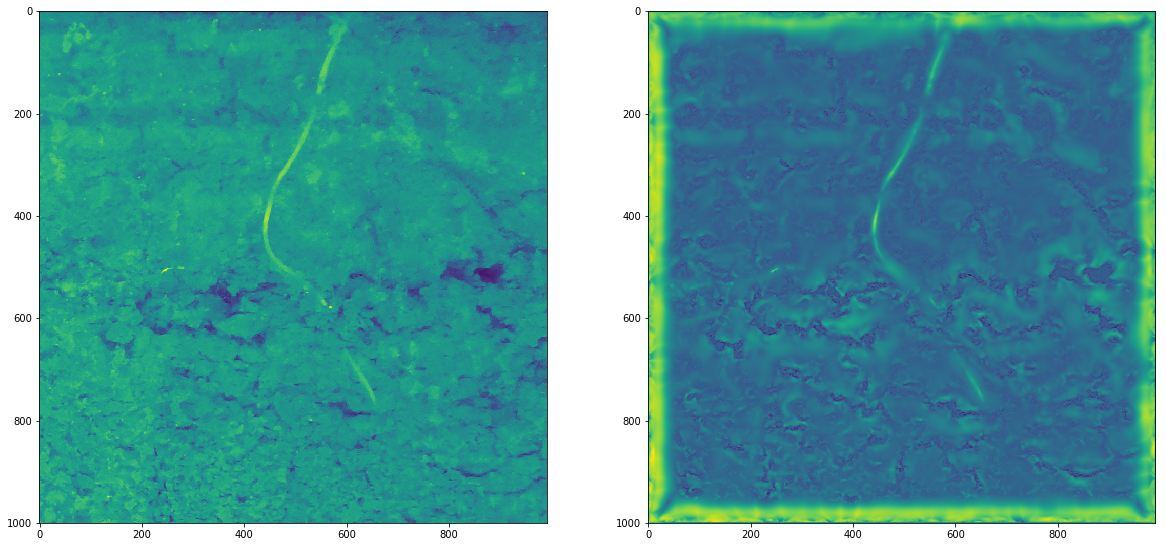

In [11]:
def ridgeDetect(image, sigmas):
    ridges = np.zeros(sigmas.shape + image.shape)

    # Filtering for all sigmas
    for i, sigma in enumerate(sigmas):       #  enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
        D = hessian_matrix(image, sigma, order='rc') # Make 2D hessian
        D = np.array(D) * (sigma ** 2)               # Correct for scale        
        lambda1, lambda2 = hessian_matrix_eigvals(D) # Calculate (abs sorted) eigenvalues and vectors
        ridges[i] = -lambda2 - np.abs(lambda1)       # Ridge strength
        
    # Max across all scales
    ridge = np.max(ridges, axis=0)
    
    return ridge

sigmas = np.arange(1, 20, 2)
ridge = ridgeDetect(smallIm, sigmas)
showTwo(smallIm, ridge)

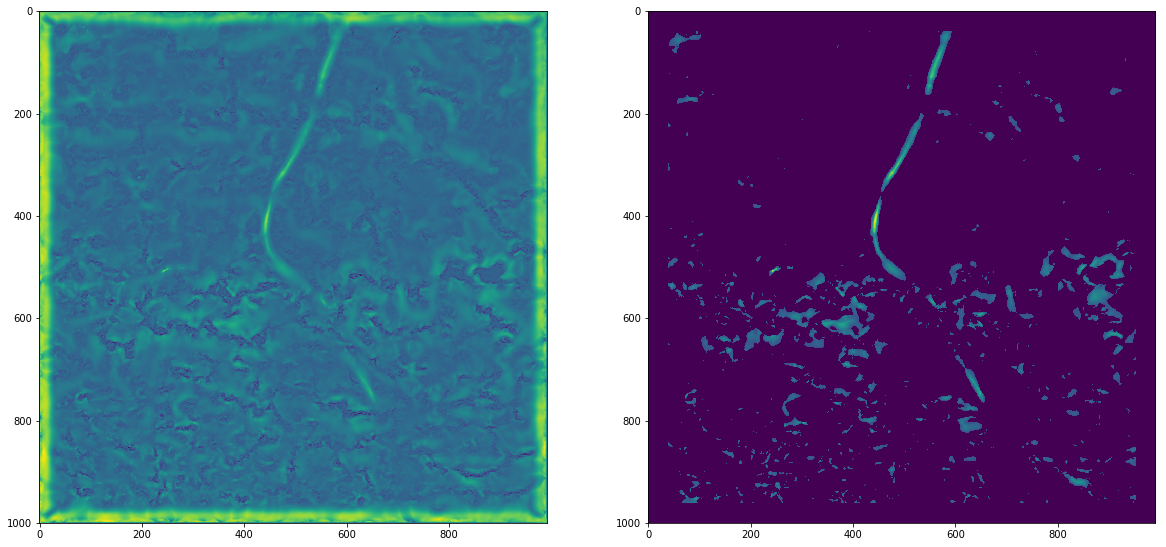

In [8]:
def cleanFeature(feat, sigmas, threshold):
   # Clean edge effect
    mrg = 3*np.max(sigmas)
    feat[:mrg,  :] = 0
    feat[-mrg:, :] = 0
    feat[:, :mrg] = 0
    feat[:, -mrg:] = 0
    
    feat[feat<threshold] = 0
    
    return feat
    
sigmas = np.arange(1, 15, 2)
threshold = 0.03
ridge = ridgeDetect(smallIm, sigmas)
cleaned = cleanFeature(ridge.copy(), sigmas, threshold)
showTwo(ridge, cleaned)

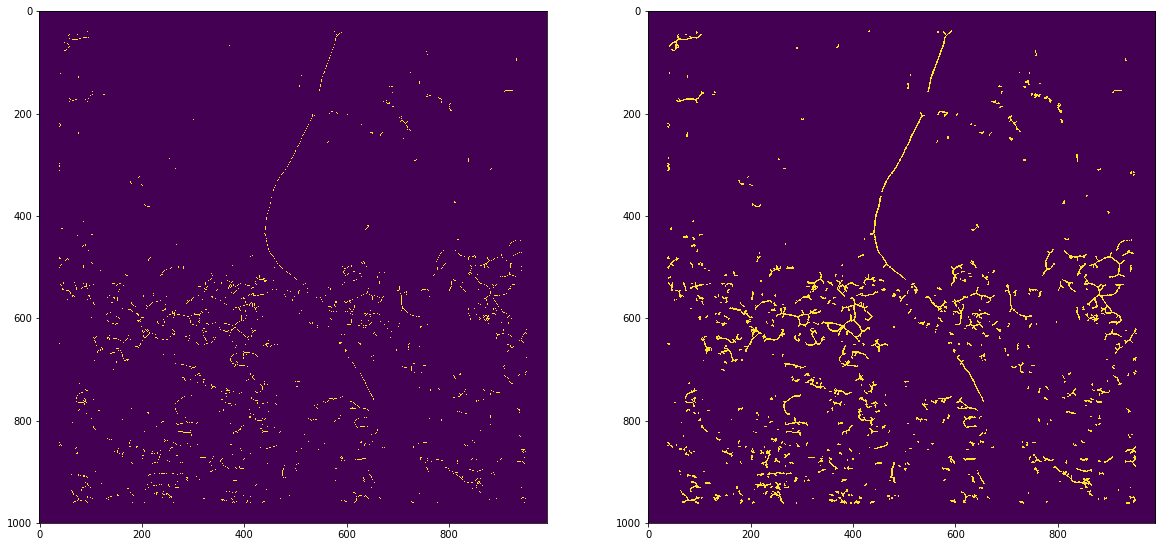

In [9]:
from skimage import img_as_bool, morphology

bin = img_as_bool(cleaned>0)
skel = morphology.medial_axis(bin)
plus = morphology.dilation(skel)

showTwo(skel, plus)

630


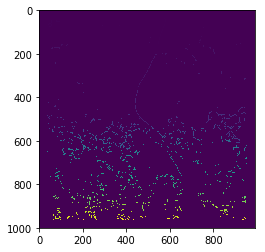

In [10]:
from scipy import ndimage

skel = plus
labeled, compCount = ndimage.label(skel)

print(compCount)
plt.imshow(labeled);

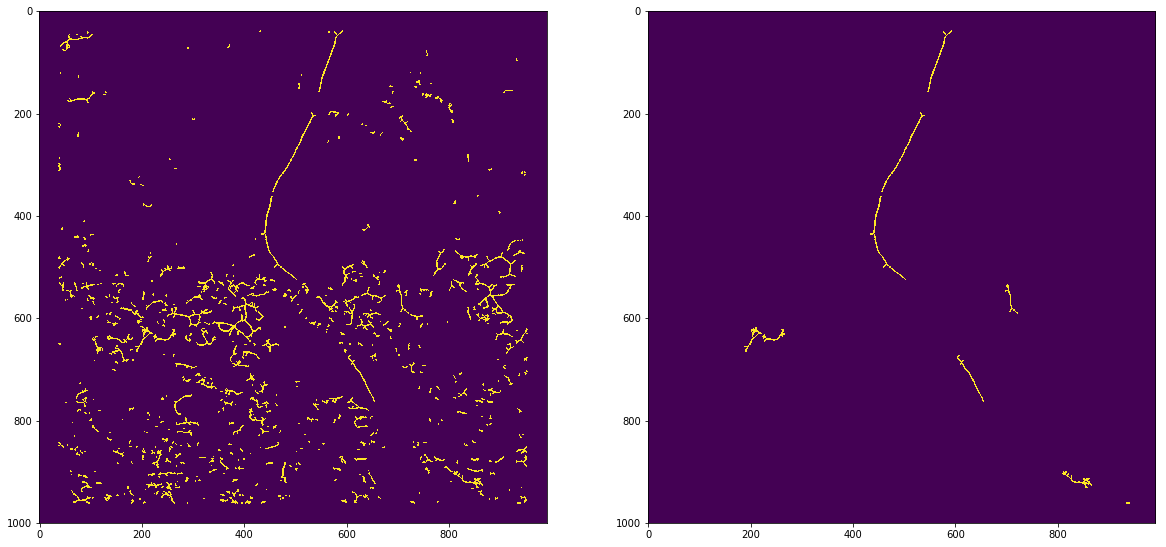

In [11]:
from scipy import linalg

roots = skel.copy()
for i in np.arange(compCount):
    mask = labeled==i
    coors = np.argwhere(mask);
    if coors.shape[0] < 200:
        roots[mask] = 0
        continue
    cov = np.cov(coors, rowvar=False)
    evals, evecs = linalg.eigh(cov)
    evals = np.abs(evals)
    if np.max(evals) < 10 * np.min(evals):
        roots[mask] = 0
        
showTwo(skel, roots)